In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict, deque

In [3]:
class TicTacToe:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = np.zeros(9, dtype=int)
        self.done = False
        self.winner = None
        return self.board.copy()

    def available_actions(self):
        return [i for i in range(9) if self.board[i] == 0]

    def step(self, action, player):
        self.board[action] = player
        self._check_terminal()
        return self.board.copy(), self.done, self.winner

    def _check_terminal(self):
        wins = [
            (0,1,2),(3,4,5),(6,7,8),
            (0,3,6),(1,4,7),(2,5,8),
            (0,4,8),(2,4,6)
        ]
        for a,b,c in wins:
            s = self.board[a] + self.board[b] + self.board[c]
            if s == 3:
                self.done, self.winner = True, 1
                return
            if s == -3:
                self.done, self.winner = True, -1
                return
        if 0 not in self.board:
            self.done, self.winner = True, 0

In [4]:
class Agent:
    def __init__(self, epsilon=0.0, alpha=0.1):
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = defaultdict(float)
        self.history = []

    def choose_action(self, state, actions):
        if random.random() < self.epsilon:
            return random.choice(actions)

        qs = [self.Q[(tuple(state), a)] for a in actions]
        max_q = max(qs)

        # Random tie-breaking among best actions
        best_actions = [a for a, q in zip(actions, qs) if q == max_q]
        return random.choice(best_actions)

    def store(self, state, action):
        self.history.append((tuple(state), action))

    def learn(self, reward):
        for s, a in reversed(self.history):
            self.Q[(s, a)] += self.alpha * (reward - self.Q[(s, a)])
            reward = self.Q[(s, a)]
        self.history = []


In [5]:
def train(agent1, agent2, games):
    env = TicTacToe()
    win_trace = []
    window = deque(maxlen=100)

    for g in range(games):
        state = env.reset()
        current = agent1

        while not env.done:
            actions = env.available_actions()
            action = current.choose_action(state, actions)
            current.store(state, action)

            state, done, winner = env.step(
                action, 1 if current == agent1 else -1
            )
            current = agent2 if current == agent1 else agent1

        # ===== Reward logic =====
        if winner == 1:          # Agent 1 (X) wins
            r1, r2 = 1.0, 0.0
            window.append(1)

        elif winner == -1:       # Agent 2 (O) wins
            r1, r2 = 0.0, 1.0
            window.append(0)

        else:                    # Draw
            r1 = r2 = 0.5
            window.append(0.5)
        # =======================

        agent1.learn(r1)
        agent2.learn(r2)

        win_trace.append(np.mean(window))

    return win_trace


In [6]:
GAMES = 3000

experiments = {
    "Greedy vs Greedy": (Agent(0.0), Agent(0.0)),
    "Greedy vs ε-Greedy": (Agent(0.0), Agent(0.1)),
    "ε-Greedy vs Greedy": (Agent(0.1), Agent(0.0)),
    "ε-Greedy vs ε-Greedy": (Agent(0.1), Agent(0.1)),
}

results = {}

for name, (a1, a2) in experiments.items():
    print(f"Training: {name}")
    trace = train(a1, a2, GAMES)
    results[name] = (trace, a1, a2)


Training: Greedy vs Greedy


Training: Greedy vs ε-Greedy
Training: ε-Greedy vs Greedy
Training: ε-Greedy vs ε-Greedy


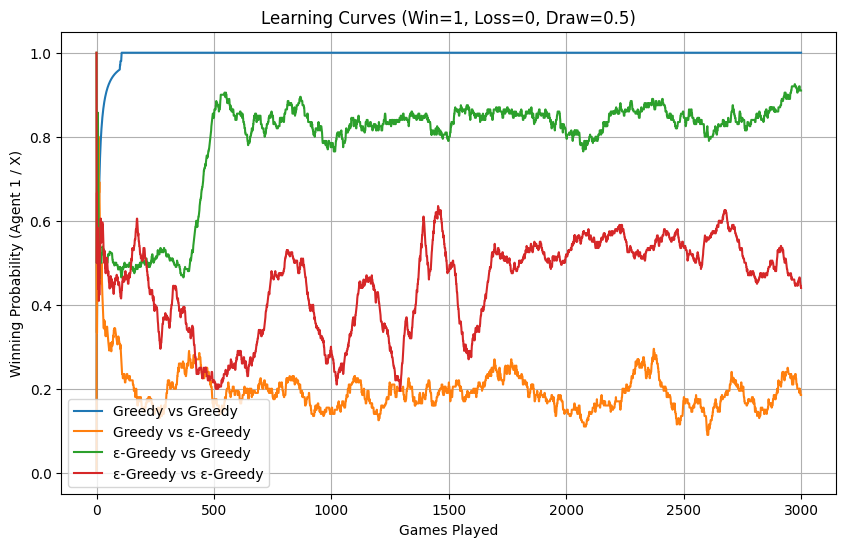

In [7]:
plt.figure(figsize=(10,6))
for name, (trace, _, _) in results.items():
    plt.plot(trace, label=name)

plt.xlabel("Games Played")
plt.ylabel("Winning Probability (Agent 1 / X)")
plt.title("Learning Curves (Win=1, Loss=0, Draw=0.5)")
plt.legend()
plt.grid()
plt.show()